# Fun with PHAT!
The Panchromatic Hubble Andromeda Treasury (PHAT; PI Dalcanton) is a Hubble Space Telescope Multi-cycle program to map roughly a third of M31's star forming disk, using 6 filters covering from the ultraviolet through the near infrared. 

The Data Lab hosts two main tables from PHAT: the version 2 object table (phat_v2.phot_mod) and the version 2 single epoch measurement table (phat_v2.phot_meas).  The object table contains average photometry in all filters, with one row per object.  The measurement table contains all of the photometric measurements for all objects, with one row per measurement.  The measurement table contains ~7.5 billion rows.

In this notebook, we'll use these tables to do some exploration of the PHAT survey.


### Imports and authentication
Import some packages for data handling and plotting. Also import datalab code.  Get the authentication token.

In [3]:
import numpy as np
import pandas as pd
import pylab as plt
import matplotlib
import astropy.utils
from astropy import stats
import sys
import math
import healpy as hp
import astropy.units as u
from getpass import getpass

%matplotlib inline

# Datalab and related imports
from dl import authClient as ac, queryClient as qc, helpers

In [4]:
token = ac.login('anonymous')

### Construct a query
First, let's get the number of rows in the PHAT_v2 object table.  There are a couple of ways to do this.  One way is to have the database count all the rows.  This is relatively slow (though still less than a minute for the object table), because the query scans the full table.  The faster way is just to retrieve the precomputed number of rows from the statistics table.

In [5]:
query="SELECT COUNT(ra) FROM phat_v2.phot_mod" # SLOW
query="SELECT * FROM tbl_stat WHERE schema='phat_v2' and tbl_name='phot_mod'" # Retrieve useful stats, quickly
query="SELECT nrows FROM tbl_stat WHERE schema='phat_v2' and tbl_name='phot_mod'" # FAST

In [6]:
%%time
try:
    nrows = qc.query(token,sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print e.message

CPU times: user 23 ms, sys: 5 ms, total: 28 ms
Wall time: 155 ms


In [7]:
print(nrows)

nrows
118774088



### Examine the columns of the PHAT object table
First, we'll take a look at some rows from phat_v2.phot_mod, and get all columns.

In [8]:
query = """SELECT *
           FROM phat_v2.phot_mod
           LIMIT 100
        """

In [9]:
%%time
try:
    result = qc.query(token,sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print e.message

CPU times: user 20 ms, sys: 2 ms, total: 22 ms
Wall time: 81.2 ms


#### Convert the output to a Pandas Dataframe
Pandas dataframes are a convenient way to store and work with the data.  The Data Lab 'helpers' module has a conversion method, with many possible output formats.

In [10]:
df1 = helpers.convert(result,'pandas')
print "Number of rows:", len(df1)
print(df1.columns) # print column headings
print(len(df1.columns))

Returning Pandas dataframe
Number of rows: 100
Index([u'ra', u'dec', u'htm9', u'pix256', u'pix4096', u'random_id', u'x', u'y',
       u'ir_x', u'ir_y', u'f110w_rate', u'f110w_raterr', u'f110w_vega',
       u'f110w_err', u'f110w_chi', u'f110w_snr', u'f110w_sharp',
       u'f110w_round', u'f110w_crowd', u'f160w_rate', u'f160w_raterr',
       u'f160w_vega', u'f160w_err', u'f160w_chi', u'f160w_snr', u'f160w_sharp',
       u'f160w_round', u'f160w_crowd', u'f275w_rate', u'f275w_raterr',
       u'f275w_vega', u'f275w_err', u'f275w_chi', u'f275w_snr', u'f275w_sharp',
       u'f275w_round', u'f275w_crowd', u'f336w_rate', u'f336w_raterr',
       u'f336w_vega', u'f336w_err', u'f336w_chi', u'f336w_snr', u'f336w_sharp',
       u'f336w_round', u'f336w_crowd', u'f475w_rate', u'f475w_raterr',
       u'f475w_vega', u'f475w_err', u'f475w_chi', u'f475w_snr', u'f475w_sharp',
       u'f475w_round', u'f475w_crowd', u'f814w_rate', u'f814w_raterr',
       u'f814w_vega', u'f814w_err', u'f814w_chi', u'f814w_snr

### Make an object density map
One of the columns in the PHAT object table, pix4096, is the Healpix index (NSIDE=4096, nested scheme) for the objects's RA and Dec.  Healpix is a handy tesselation of the sky into tiles of equal area.  The Python module healpy has all of the Healpix related functions.

To make maps of aggregate quantities in PHAT, we're going to use the database to return results in a query grouped by Healpix index value.  We can then put the results into arrays, and use healpy's functionality to display the maps.

In this first query, we will the GROUP BY clause tells the database to aggregate the results by the values in the pix4096 column, and return the average RA and Dec of objects in those groups, as well as the pix4096 value itself and the count of the number of objects in the group.


In [146]:
mquery = """SELECT avg(ra) as ra0,avg(dec) as dec0,pix4096,count(pix4096) as nb
           FROM phat_v2.phot_mod
           GROUP BY pix4096
        """

In [147]:
%%time
try:
    mresult = qc.query(token,sql=mquery) # by default the result is a CSV formatted string
except Exception as e:
    print e.message

CPU times: user 27 ms, sys: 0 ns, total: 27 ms
Wall time: 1min 12s


#### Convert the output to a Pandas Dataframe
We'll once again use helpers to convert the result to a Pandas dataframe.  Our dataframe has one row per Healpix.  We'll check that the sum of the number of objects in all Healpixels equals the number of rows in the table.

In [148]:
dfm = helpers.convert(mresult,'pandas')
print "Number of rows:", len(dfm)
print np.sum(dfm['nb']) # print total counts

Returning Pandas dataframe
Number of rows: 2574
117335533


#### Making the Healpix map
A Healpix map is simply a one-dimensional array with number of elements set by the NSIDE parameter, which is the number of times the base Healpixels are split.

In [149]:
hmap=np.zeros(hp.nside2npix(4096))

In [150]:
print(dfm.head())
print(np.median(dfm['ra0']),np.median(dfm['dec0']))

         ra0       dec0   pix4096     nb
0  11.239025  41.610492  10747797  68020
1  11.294279  41.722430  10747868  63630
2  11.693241  41.890020  10922465  12500
3  11.457172  41.810363  10922601  51534
4  11.843336  42.047941  10923119  22544
(11.271882914997001, 41.697835806211046)


#### Populating the Healpix map
Now we set the elements of our Healpix map to the number of objects returned by the query, calculate the center of the RA and Dec distribution of the objects, and use healpy's gnomview to visualize the output. Notice anything funny?  The PHAT object table has duplicate objects between some of the bricks (bricks 11, 12, 13, and 14).

In [151]:
hmap[dfm['pix4096']]=dfm['nb']
(rarot,decrot)=(np.median(dfm['ra0']),np.median(dfm['dec0']))

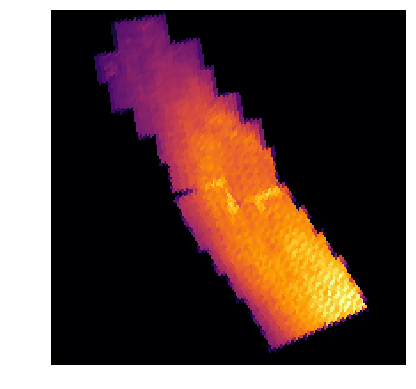

In [153]:
hp.gnomview(hmap,title='',notext=True,cbar=False,reso=0.4,nest=True,rot=(rarot,decrot,0),cmap='inferno',min=1e3,max=8e4)


### Make depth and color maps
Now we'll get a little fancier with our maps.  We'll have the database return average WFC3 u-band and ACS magnitudes and colors and the PHAT brick numbers, and make some cuts on the magnitudes and flags of the objects.  We again GROUP BY the pix4096 column.


In [18]:
mquery2 = """SELECT avg(ra) as ra0,avg(dec) as dec0,pix4096,count(pix4096) as nb,
            avg(f475w_vega) as gmag,avg(f814w_vega) as imag,avg(brick) as brick,
            avg(f475w_vega-f814w_vega) as g_i
           FROM phat_v2.phot_mod
           WHERE f475w_gst=1 AND f814w_gst=1 AND f475w_vega<50 AND f814w_vega<50
           GROUP BY pix4096
        """

In [19]:
%%time
try:
    mresult2 = qc.query(token,sql=mquery2) # by default the result is a CSV formatted string
except Exception as e:
    print e.message

CPU times: user 29 ms, sys: 3 ms, total: 32 ms
Wall time: 1min 31s


In [20]:
dfm2 = helpers.convert(mresult2,'pandas')
print "Number of rows:", len(dfm2)
print np.sum(dfm2['nb']) # print total counts

Returning Pandas dataframe
Number of rows: 2574
82741245


In [21]:
print(dfm2.head())

         ra0       dec0   pix4096     nb       gmag       imag      brick  \
0  11.238938  41.610534  10747797  74435  26.551432  24.826975  10.474454   
1  11.295046  41.721807  10747868  67822  26.572144  24.943804  12.894444   
2  11.693173  41.890007  10922465   7543  27.030190  25.735297  18.000000   
3  11.456964  41.810426  10922601  34910  26.747490  25.257324  15.918763   
4  11.842830  42.048000  10923119  11078  26.964323  25.645896  20.000000   

        g_i  
0  1.724457  
1  1.628340  
2  1.294892  
3  1.490165  
4  1.318427  


#### Healpix map of average F475W magnitude
The map of the average F475W magnitude gives a good idea of how the PHAT catalog depth variations with position in M31.  The depth is much shallower in the Bulge, which is very crowded, than in the outer disk.

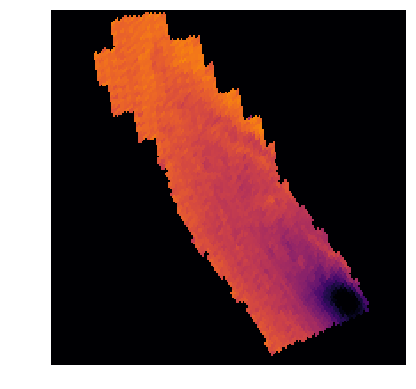

In [154]:
gmap=np.zeros(hp.nside2npix(4096))
gmap[dfm2['pix4096']]=dfm2['gmag']
hp.gnomview(gmap,title='',notext=True,cbar=False,reso=0.4,nest=True,rot=(rarot,decrot,0),cmap='inferno',min=25,max=28)

#### Healpix map of average F475W-F814W color
The map of average color reveals both population differences and the dust lanes in the galaxy, as well as the 10 kpc ring.

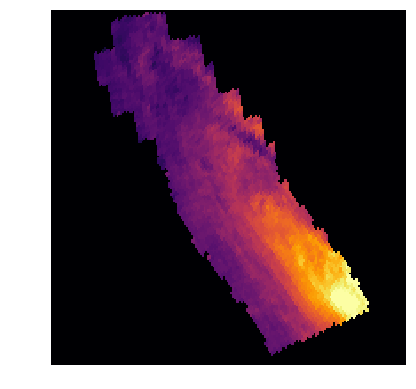

In [155]:
gimap=np.zeros(hp.nside2npix(4096))
gimap[dfm2['pix4096']]=dfm2['g_i']
hp.gnomview(gimap,title='',notext=True,cbar=False,reso=0.4,nest=True,rot=(rarot,decrot,0),cmap='inferno',min=1,max=2.5)

#### Healpix map of the brick number
We can also use our Healpix table to make a map of the PHAT bricks.

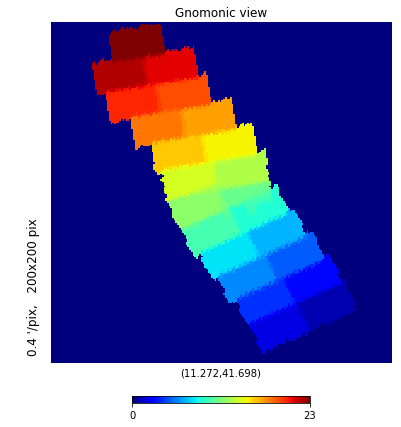

In [24]:
bmap=np.zeros(hp.nside2npix(4096))
bmap[dfm2['pix4096']]=dfm2['brick']
hp.gnomview(bmap,reso=0.4,nest=True,rot=(rarot,decrot,0),cmap='jet',min=0,max=23)

### Do a spatial query and make color-color diagrams and CMDs
Now let's do a cone search for objects within a radius of a particular position.  The PHAT tables are spatially indexed to make such queries fast.  We'll search within a 1 arcmin radius of the RA and Dec position that we defined earlier.

In [25]:
query = """SELECT *
           FROM phat_v2.phot_mod WHERE q3c_radial_query(ra,dec,%s,%s,%s)
        """ % (rarot,decrot,1./60)
print(query)

SELECT *
           FROM phat_v2.phot_mod WHERE q3c_radial_query(ra,dec,11.2718818569,41.6978430561,0.0166666666667)
        


In [26]:
%%time
try:
    result = qc.query(token,sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print e.message

CPU times: user 0 ns, sys: 25.5 s, total: 25.5 s
Wall time: 55.3 s


#### Cut out bad missing values
Some of the objects returned will have missing magnitude measurements, indicated by 99's.  Let's cut those out, and also select only the "good" stars in the ACS bands.

In [27]:
df2 = helpers.convert(result,'pandas')
print "Number of rows:", len(df2)
dfs=df2[(df2['f336w_vega']<50) & (df2['f475w_vega']<50) & (df2['f814w_vega']<50) & (df2['f475w_gst']==1) & (df2['f814w_gst']==1)]
print "Number of rows:", len(dfs)


Returning Pandas dataframe
Number of rows: 281968
Number of rows: 118174


#### Make color-color and CMD plots
We'll show the F475W-F814W,F336W-F475W color-color diagram, and a color-magnitude diagram.  What do you notice?

(28.4, 22)

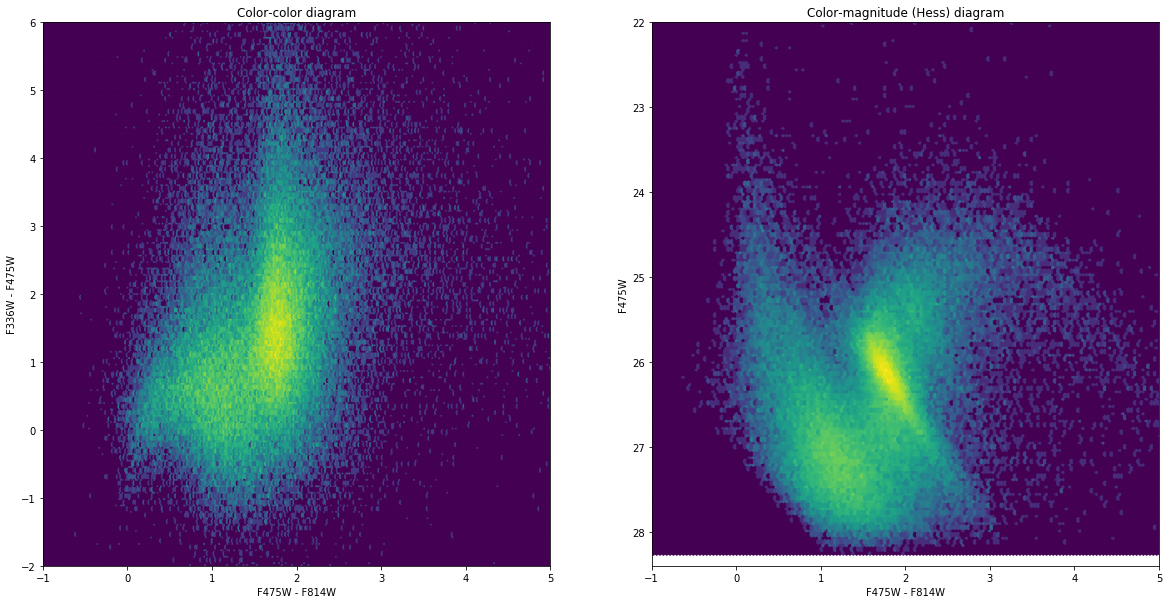

In [29]:
# make a figure
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# color-magnitude diagram (Hess diagram)
im = ax1.hexbin(dfs['f475w_vega']-dfs['f814w_vega'],dfs['f336w_vega']-dfs['f475w_vega'],gridsize=400,cmap=matplotlib.cm.viridis,norm=matplotlib.colors.LogNorm())
ax1.set_ylabel('F336W - F475W')
ax1.set_xlabel('F475W - F814W')
ax1.set_title('Color-color diagram')
ax1.set_ylim(-2,6)
ax1.set_xlim(-1,5)

# color-magnitude diagram (Hess diagram)
im2 = ax2.hexbin(dfs['f475w_vega']-dfs['f814w_vega'],dfs['f475w_vega'],gridsize=200,cmap=matplotlib.cm.viridis,norm=matplotlib.colors.LogNorm())
#cb = p.colorbar(im2,aspect=40,pad=0.01)
#cb.set_label('number of sources per 2D bin')
ax2.set_xlabel('F475W - F814W')
ax2.set_ylabel('F475W')
ax2.set_title('Color-magnitude (Hess) diagram')
ax2.set_xlim(-1,5)
ax2.set_ylim(28.4,22)
#ax2.scatter(dfs['f475w_vega']-dfs['f814w_vega'],dfs['f475w_vega'])

### Retrieving time series photometry of select objects
In this part of the notebook, we'll pick a Cepheid variable, and then query the full measurement table for the time series photometry.  

In [81]:
rawk=11.02203
decwk=41.23451
best_period=10.29 # days
#rawk=11.33250
#decwk=41.78882
#best_period=10.971
query="""SELECT * FROM phat_v2.phot_meas WHERE q3c_radial_query(ra,dec,%s,%s,%s)""" % (rawk,decwk,0.2/3600)
print(query)

SELECT * FROM phat_v2.phot_meas WHERE q3c_radial_query(ra,dec,11.02203,41.23451,5.55555555556e-05)


In [82]:
%%time
try:
    result = qc.query(token,sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print e.message

CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 218 ms


In [83]:
df0 = helpers.convert(result,'pandas')
#df0=df0[(df0['objid']==objid0)]
print "Number of rows:", len(df0)
print(df0['filter'].unique())
print(df0['objid'].unique())


Returning Pandas dataframe
Number of rows: 62
['F475W' 'F275W' 'F336W' 'F814W' 'F160W' 'F110W']
['PHAT_11.0220304+41.234515']


In [84]:
uid=df0['objid'].unique()
df0=df0[(df0['objid']==uid[0])]

In [85]:
t475,y475,dy475 = get_data(df0,'F475W')
t275,y275,dy275 = get_data(df0,'F275W')
t336,y336,dy336 = get_data(df0,'F336W')
t814,y814,dy814 = get_data(df0,'F814W')
t160,y160,dy160 = get_data(df0,'F160W')
t110,y110,dy110 = get_data(df0,'F110W')

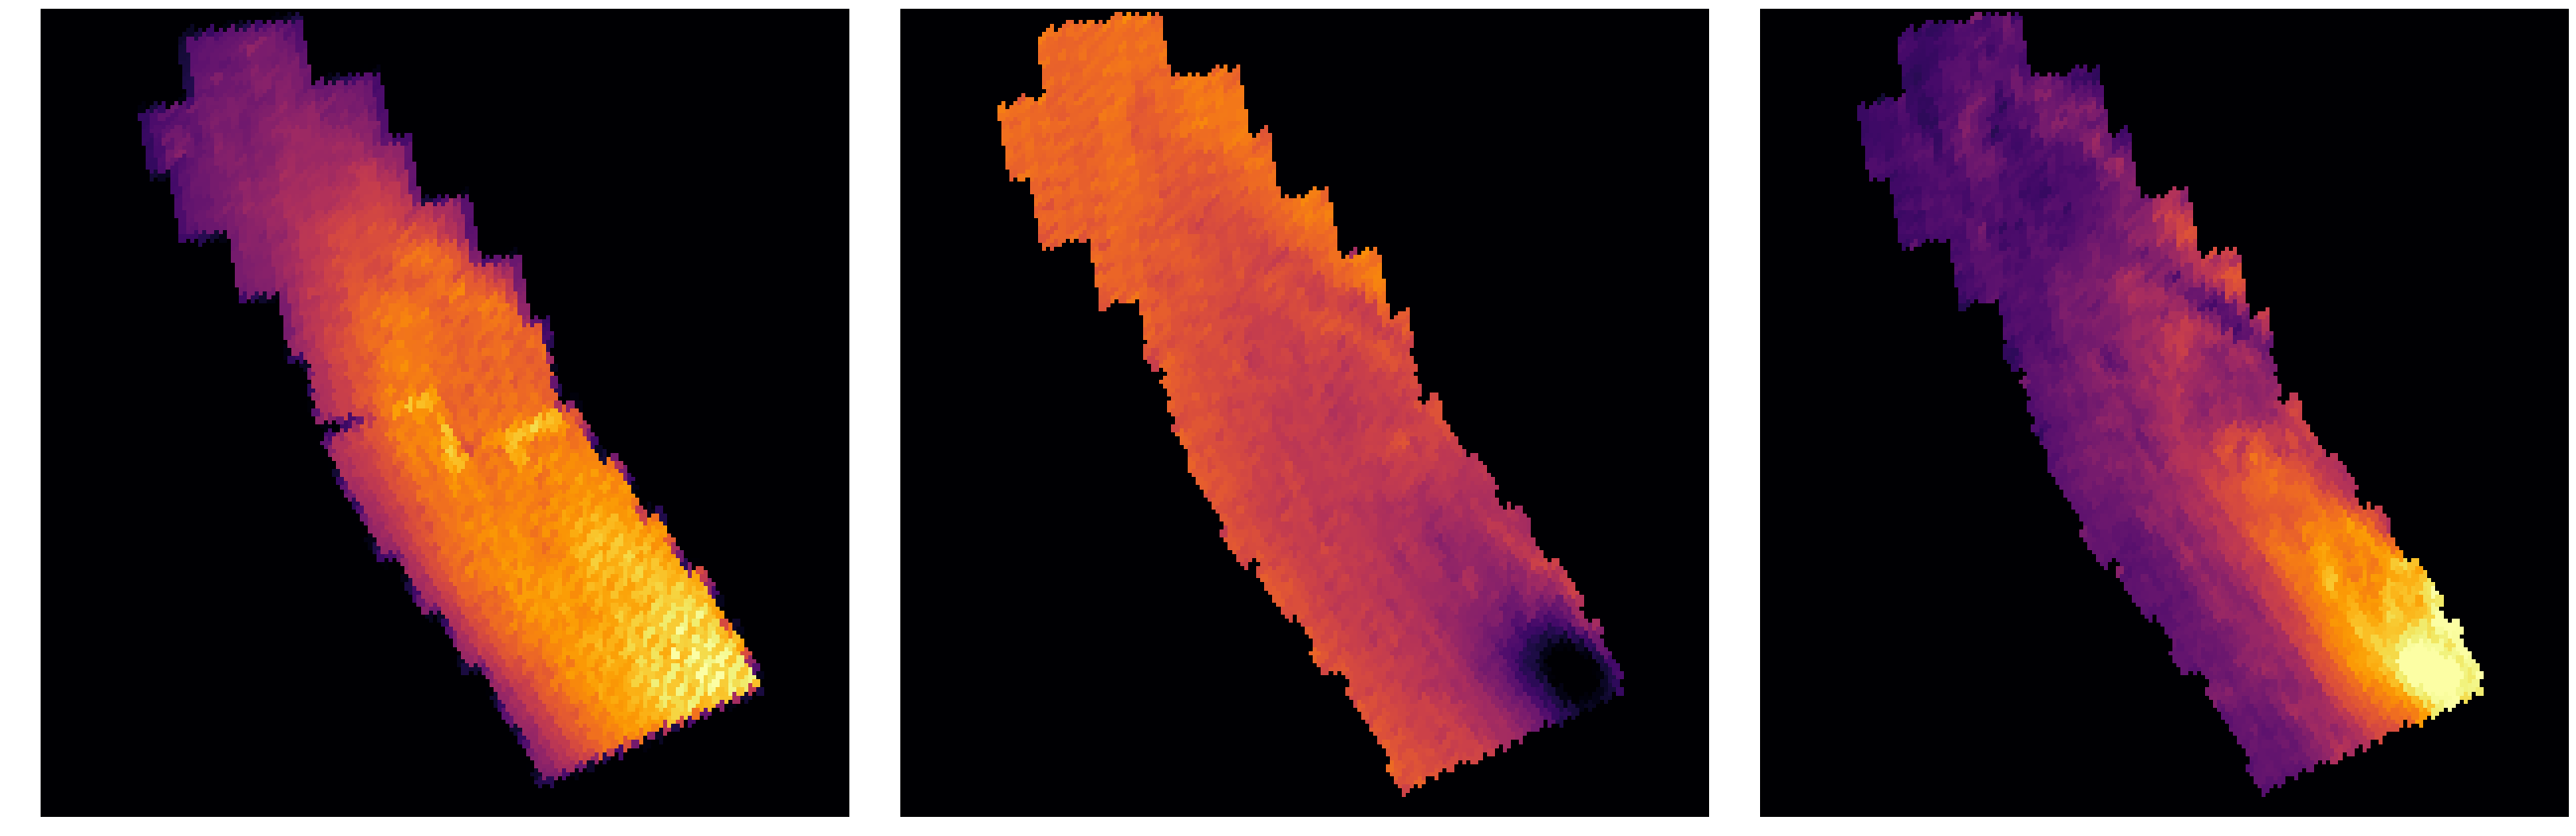

In [184]:
plt.figure(figsize=(45, 15))
hp.gnomview(hmap,title='',notext=True,cbar=False,reso=0.4,nest=True,rot=(rarot,decrot,0),cmap='inferno',min=1e3,max=8e4,sub=(131))
hp.gnomview(gmap,title='',notext=True,cbar=False,reso=0.4,nest=True,rot=(rarot,decrot,0),cmap='inferno',min=25,max=28,sub=(132))
hp.gnomview(gimap,title='',notext=True,cbar=False,reso=0.4,nest=True,rot=(rarot,decrot,0),cmap='inferno',min=1,max=2.5,sub=(133))


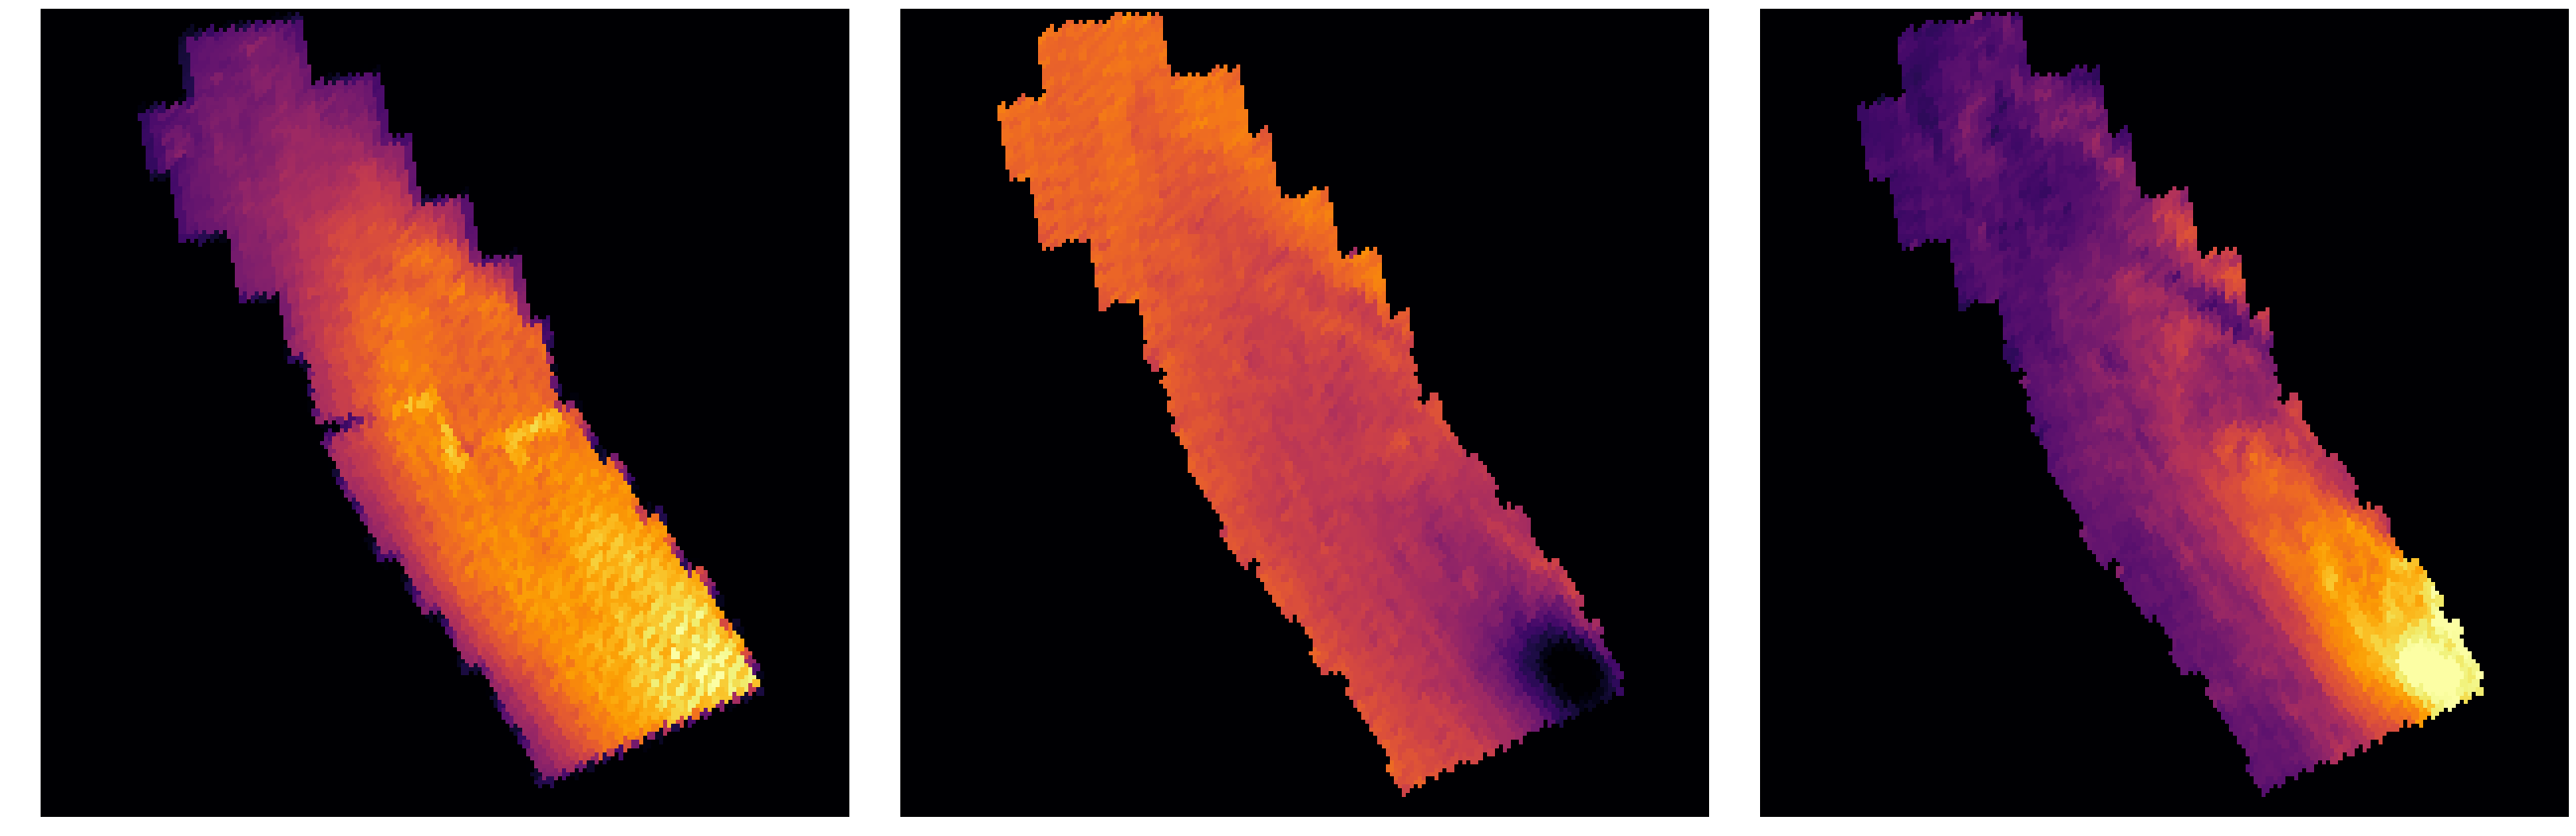

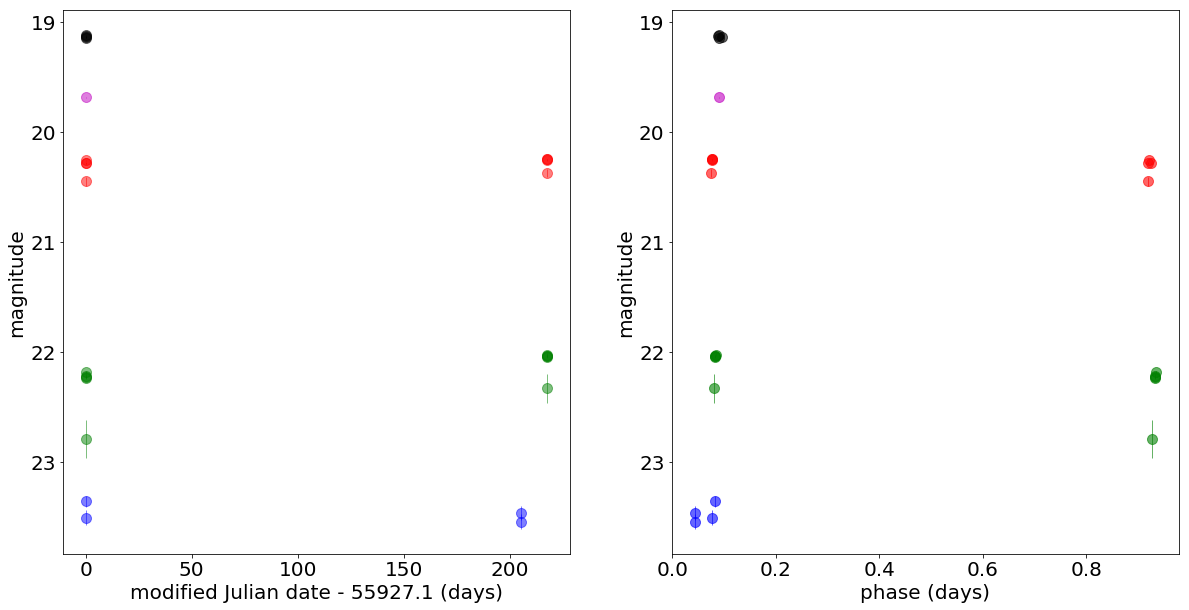

In [185]:
plt.figure(figsize=(45, 15))
hp.gnomview(hmap,title='',notext=True,cbar=False,reso=0.4,nest=True,rot=(rarot,decrot,0),cmap='inferno',min=1e3,max=8e4,sub=(131))
hp.gnomview(gmap,title='',notext=True,cbar=False,reso=0.4,nest=True,rot=(rarot,decrot,0),cmap='inferno',min=25,max=28,sub=(132))
hp.gnomview(gimap,title='',notext=True,cbar=False,reso=0.4,nest=True,rot=(rarot,decrot,0),cmap='inferno',min=1,max=2.5,sub=(133))

# make a figure
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
plot_raw_lightcurve(t475,y475,dy475,title='',ax=ax1,color='g',ms=20)
plot_raw_lightcurve(t814,y814,dy814,title='',ax=ax1,color='r',ms=20)
#plot_raw_lightcurve(t275,y275,dy275,title='time series',ax=ax1,color='c',ms=20)
plot_raw_lightcurve(t336,y336,dy336,title='',ax=ax1,color='b',ms=20)
plot_raw_lightcurve(t160,y160,dy160,title='',ax=ax1,color='k',ms=20)
plot_raw_lightcurve(t110,y110,dy110,title='',ax=ax1,color='m',ms=20)

ax2 = fig.add_subplot(122)
#ax2.set_title('Folded light curve')
plot_folded_lightcurve(t475,y475,best_period,dy=dy475,ax=ax2,color='g',ms=20)
plot_folded_lightcurve(t814,y814,best_period,dy=dy814,ax=ax2,color='r',ms=20)
#plot_folded_lightcurve(t275,y275,best_period,dy=dy275,ax=ax2,color='c',ms=20)
plot_folded_lightcurve(t336,y336,best_period,dy=dy336,ax=ax2,color='b',ms=20)
plot_folded_lightcurve(t160,y160,best_period,dy=dy160,ax=ax2,color='k',ms=20)
plot_folded_lightcurve(t110,y110,best_period,dy=dy110,ax=ax2,color='m',ms=20)

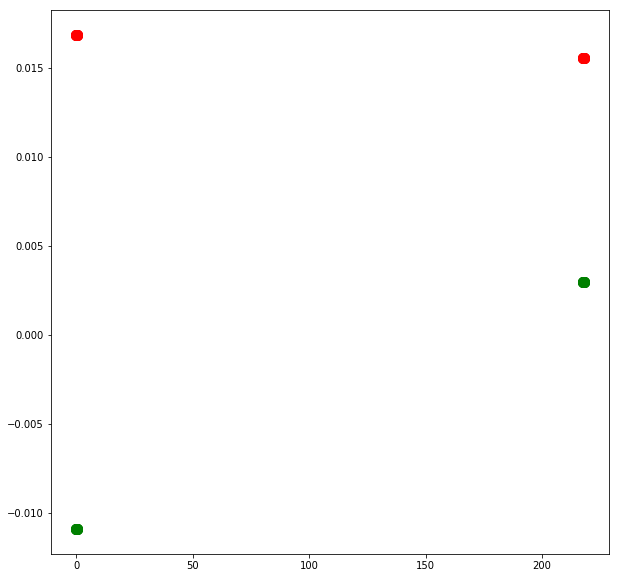

In [88]:
dacs=df0[(df0['filter']=='F475W') | (df0['filter']=='F814W')]
dra=(dacs['ra']-rawk)*3600
ddec=(dacs['dec']-decwk)*3600
t=dacs['mjd'].values-dacs['mjd'].values.min()
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.plot(t,dra,marker='.',ms=20,ls='none',lw=1,color='g',alpha=0.6)
ax1.plot(t,ddec,marker='.',ms=20,ls='none',lw=1,color='r',alpha=0.6)

In [93]:
query="""SELECT * FROM phat_v2.phot_meas WHERE q3c_radial_query(ra,dec,%s,%s,%s)""" % (rawk,decwk,1./3600)
print(query)

SELECT * FROM phat_v2.phot_meas WHERE q3c_radial_query(ra,dec,11.02203,41.23451,0.000277777777778)


In [94]:
%%time
try:
    result = qc.query(token,sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print e.message

CPU times: user 38 ms, sys: 0 ns, total: 38 ms
Wall time: 1min 3s


In [111]:
df1 = helpers.convert(result,'pandas')
print "Number of rows:", len(df1)
dacs=df1[(df1['filter']=='F475W') | (df1['filter']=='F814W')]
#dra=(dacs['ra']-rawk)*3600
#ddec=(dacs['dec']-decwk)*3600
#t=dacs['mjd'].values-dacs['mjd'].values.min()
#fig = plt.figure(figsize=(10,10))
#ax1 = fig.add_subplot(111)
#ax1.plot(t,dra,marker='.',ms=20,ls='none',lw=1,color='g',alpha=0.6)
#ax1.plot(t,ddec,marker='.',ms=20,ls='none',lw=1,color='r',alpha=0.6)

Returning Pandas dataframe
Number of rows: 3131


In [112]:
grp=df1.groupby(['objid','mjd'])
dfs=grp.aggregate(np.mean)

In [138]:
dfs.index

('PHAT_11.0217083+41.234630', 55915.029840900002)

#### The 'objid' column doesn't have an index yet, so we'll use the position of the object to find it in phot_v2.phot_meas

In [35]:
# define a function to select only measurements in one band
def get_data(df,band='F475W'):
    sel = (df['filter'] == band) & (df['magvega'] < 90)    
    t = df['mjd'][sel].values
    y = df['magvega'][sel].values
    dy = df['magerr'][sel].values
    return t,y,dy # return time, magnitudes in one band, uncertainties

In [163]:
#t,y,dy = get_data(df0,'F475W')  # select one band

# a reusable function to plot the lightcurve
def plot_raw_lightcurve(t,y,dy,title='',ax=None,lperc=13,rperc=99,color='g',ms=8):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    jd0 = t.min() # modified Julian date offset
    t = t-jd0 # first date of observations = 0

    ax.errorbar(t,y,yerr=dy,marker='.',ms=ms,ls='none',color=color,lw=1,alpha=0.5,label='')

    # Main panel chores
    ax.set_xlabel('modified Julian date - %g (days)' % jd0, fontsize=20)
    ax.set_ylabel('magnitude',fontsize=20)
    ax.tick_params(labelsize=20)
    ax.invert_yaxis()
    ax.set_title(title)


In [51]:
def get_folded_phase(t,best_period):
    
    """Fold the observation times with the best period of the variable signal."""
    
    # light curve over period, take the remainder (i.e. the "phase" of one period)
    phase = (t / best_period) % 1
    
    return phase

In [161]:
def plot_folded_lightcurve(t,y,best_period,dy=None,ax=None,color='g',ms=10):
    
    """Plot folded lightcurve.
    
    Parameters
    ----------
    
    t, y : array
        Time and magnitude 1-d arrays
        
    best_period : float
        True period of the signal.
        
    dy : array or None
        If array, the values are the uncertainies on ``y``, and the plot will show errorbars.
        If None, the plot will have no errorbars.
        
    ax : instance or None
        If instance of axis class, will plot to that object. If None, will generate a new figure and axis object.
    """

    phase = get_folded_phase(t,best_period)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    marker = '.'
    lw = 1
    alpha = 0.6
    
    
    if dy is not None:
        ax.errorbar(phase,y,yerr=dy,marker=marker,ms=ms,ls='none',lw=lw,color=color,alpha=alpha)
    else:
        ax.plot(phase,y,marker=marker,ms=ms,ls='none',lw=lw,color=color,alpha=alpha)
            
    ax.invert_yaxis()
    ax.tick_params(labelsize=20)
    ax.set_xlabel('phase (days)', fontsize=20)
    ax.set_ylabel('magnitude',fontsize=20);